# Generate Data For Cospectra Likelihood Explorations

This notebook generates test data and sample distributions for the work on the cospectra likelihood.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack
from tqdm import tqdm

from stingray import Lightcurve, Crossspectrum, Powerspectrum
from stingray import AveragedPowerspectrum, AveragedCrossspectrum
from stingray.simulator.simulator import Simulator

datadir = "../data/"

# the indices of the frequencies to store
# We will not store full periodograms etc for 
# space reasons
idx_all = [10, 100, 1000]

/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/largememory.py:25: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  warnings.warn(
/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/crossspectrum.py:28: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/crosscorrelation.py:8: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/bispectrum.py:10: User

## Simulating Light curves and Periodograms

We want to simulate a large number of light curves and periodograms so we can use them later to generate distributions. We should probably store them in separate files to deal with memory issues.

We are generating a light curve with $N_\mathrm{data} =10000$ data points, a time resolution of $\Delta t = 0.0001$, a mean count rate that is absurdly high, $1000$ counts/bin, and a fractional rms amplitude of $\mathrm{rms}_f = 0.2$.

In [2]:
npoints = 10000
dt = 0.0001

plidx_true = 2.0
rms_true = 0.2
mean_true = 1000.0

# set the random state for reproducibility
rng = np.random.RandomState(100)
sim = Simulator(dt=dt, N=npoints, mean=mean_true, rms=rms_true, random_state=rng)

In [3]:
lc = sim.simulate(2.0)

/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [4]:
np.mean(lc.countrate)

10000000.000000002

<IPython.core.display.Javascript object>


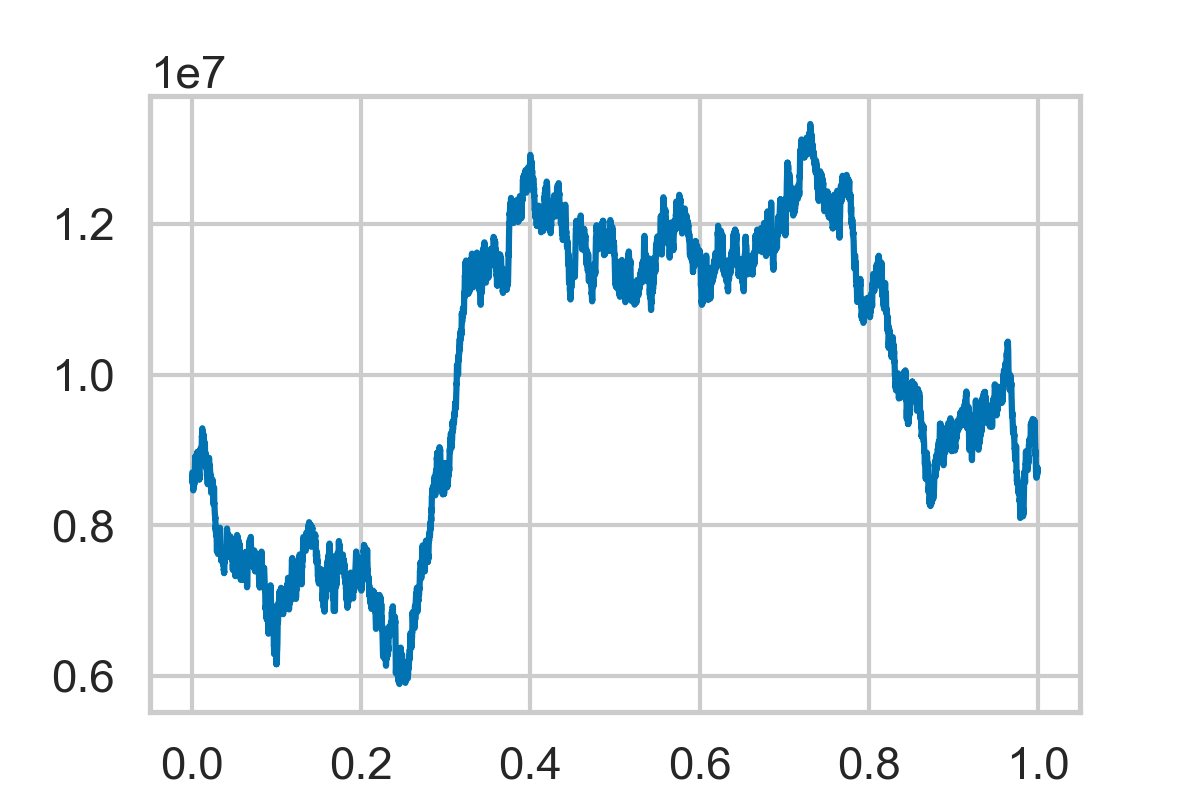

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(lc.time, lc.countrate)

We are now generating a million light curves/periodograms, and store them in 100 files of 10000 examples each:

In [8]:
import warnings
warnings.filterwarnings('ignore')

## Generate an Averaged Periodogram


Use five hundred light curves to generate an averaged periodogram. This is valuable for fitting a function to the "true" spectrum, and for plotting later.

In [9]:
# the number of simulations to run
nsim_per = 5000

#fourier1_all, fourier2_all, csd_all, csd_normed_all = [], [], [], []
#fourier_squared_test, fourier_squared_test_lc1 = [], []
#fdiff_all = []
lc1_counts_all, lc2_counts_all = [], []
lc_rn_all, lc1_all, lc2_all = [], [], []
#ps1_all, ps2_all = [], []

for i in tqdm(range(nsim_per)):
    #print(i)
    lc = sim.simulate(plidx_true)
    
    try:
        counts1 = rng.poisson(lc.counts)
        counts2 = rng.poisson(lc.counts)
    except ValueError:
        continue
        
    lc1 = Lightcurve(lc.time, counts1, dt=dt, skip_checks=True)
    lc2 = Lightcurve(lc.time, counts2, dt=dt, skip_checks=True)
    
    lc1_counts_all.append(np.sum(lc1.counts))
    lc2_counts_all.append(np.sum(lc2.counts))
    
    lc1_all.append(lc1)
    lc2_all.append(lc2)
    lc_rn_all.append(lc)

    if i == 0:
        test_lc_rn = lc
        test_ps_rn = Powerspectrum(lc, norm="leahy")
        test_ps1 = Powerspectrum(lc1, norm="leahy")
        test_ps2 = Powerspectrum(lc2, norm="leahy")
        test_cs = Crossspectrum(lc1, lc2, norm="leahy")


    

100%|██████████| 5000/5000 [00:14<00:00, 336.54it/s]


<IPython.core.display.Javascript object>


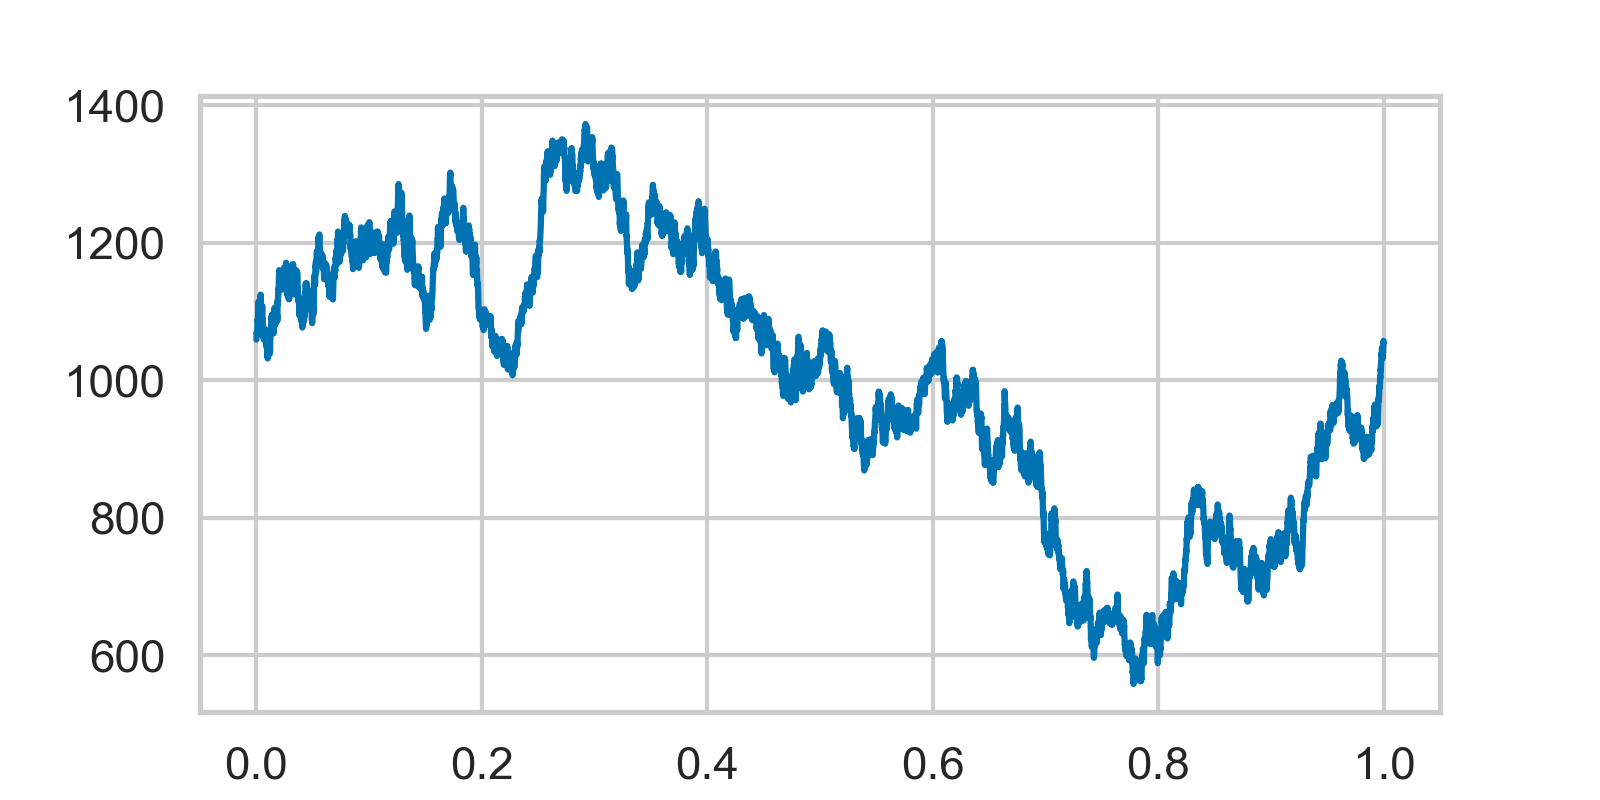

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lc1.time, lc_rn_all[0])

In [12]:
avg_ps1 = AveragedPowerspectrum(lc1_all, segment_size=lc1_all[0].tseg, norm="leahy")
avg_ps2 = AveragedPowerspectrum(lc2_all, segment_size=lc1_all[0].tseg, norm="leahy")
avg_cs = AveragedCrossspectrum(lc1_all, lc2_all, segment_size=lc1_all[0].tseg, norm="leahy")

avg_ps_rn = AveragedPowerspectrum(lc_rn_all, segment_size=lc_rn_all[0].tseg, norm="leahy")

5000it [00:10, 476.41it/s]
5000it [00:08, 572.82it/s]
5000it [00:39, 126.95it/s]
5000it [00:35, 142.41it/s]
5000it [00:32, 154.60it/s]
5000it [00:08, 588.22it/s]


Let's save this to file. The first column contains the frequencies, the second the power in the periodogram without white noise (red noise only), the third contains the power in the periodogram of lc1, the fourth the power in the periodogram of lc2, and the last row contains the cospectrum.

In [13]:
np.savetxt(datadir + "avg_per.dat", 
           np.array([avg_ps1.freq, avg_ps_rn.power, 
                     avg_ps1.power, avg_ps2.power, 
                     avg_cs.power]).T)

I also want to save a test light curve, periodogram and cospectrum for future use:

In [14]:
np.savetxt(datadir + "test_lc.dat", 
           np.array([test_lc_rn.time, test_lc_rn.counts, test_lc_rn.countrate]).T)

np.savetxt(datadir + "test_psd.dat", 
           np.array([test_ps1.freq, test_ps_rn.power, 
                     test_ps1.power, test_ps2.power, 
                     test_cs.power]).T)


Let's fit a model to this so that we have some measure of the true underlying power spectrum:

In [15]:
from astropy.modeling import models
from stingray.modeling import PSDLogLikelihood, PSDParEst

In [23]:
m = models.PowerLaw1D() + models.Const1D()
m.x_0_0.fixed=True

loglike = PSDLogLikelihood(avg_ps1.freq, avg_ps1.power, model=m, m=avg_ps1.m)
parest = PSDParEst(avg_ps1, max_post=False,  fitmethod="Nelder-Mead")
res = parest.fit(loglike, [2.4e4, 2.5, 2])

print("best-fit parameters: " + str(res.p_opt))

best-fit parameters: [3.22621763e+05 1.98821852e+00 1.99791347e+00]


Let's do the same with red noise only (light curves without Poisson statistics):

In [24]:
mrn = models.PowerLaw1D() + models.Const1D()
mrn.x_0_0.fixed=True

loglike_rn = PSDLogLikelihood(avg_ps_rn.freq, avg_ps_rn.power, model=mrn, m=avg_ps_rn.m)

parest_rn = PSDParEst(avg_ps_rn, max_post=False, fitmethod="Nelder-Mead")
res_rn = parest_rn.fit(loglike_rn, [2.4e4, 2.5, 0.0])
print("best-fit parameters (red noise only): " + str(res_rn.p_opt))

mrn.amplitude_0 = res_rn.p_opt[0]
mrn.alpha_0 = res_rn.p_opt[1]
mrn.amplitude_1 = res_rn.p_opt[2]

mps_rn = mrn(avg_ps_rn.freq)

best-fit parameters (red noise only): [ 3.36176336e+05  1.99709742e+00 -9.63148364e-05]


Let's save the best-fit parameters to file:

In [25]:
np.savetxt(datadir + "opt_pars.dat", np.vstack([res.p_opt, res_rn.p_opt]))

Let's plot the result to check:

In [26]:
m.amplitude_0 = res.p_opt[0]
m.alpha_0 = res.p_opt[1]
m.amplitude_1 = res.p_opt[2]
mps = m(avg_ps1.freq)

mrn.amplitude_0 = res_rn.p_opt[0]
mrn.alpha_0 = res_rn.p_opt[1]
mrn.amplitude_1 = res_rn.p_opt[2]
mps_rn = mrn(avg_ps_rn.freq)

In [27]:
for idx in idx_all:
    print((avg_ps_rn.power[idx] - mps_rn[idx]))

-1.878066520365337
0.2735445130096039
-0.004223512430661824


In [28]:
idx_all

[10, 100, 1000]

<IPython.core.display.Javascript object>


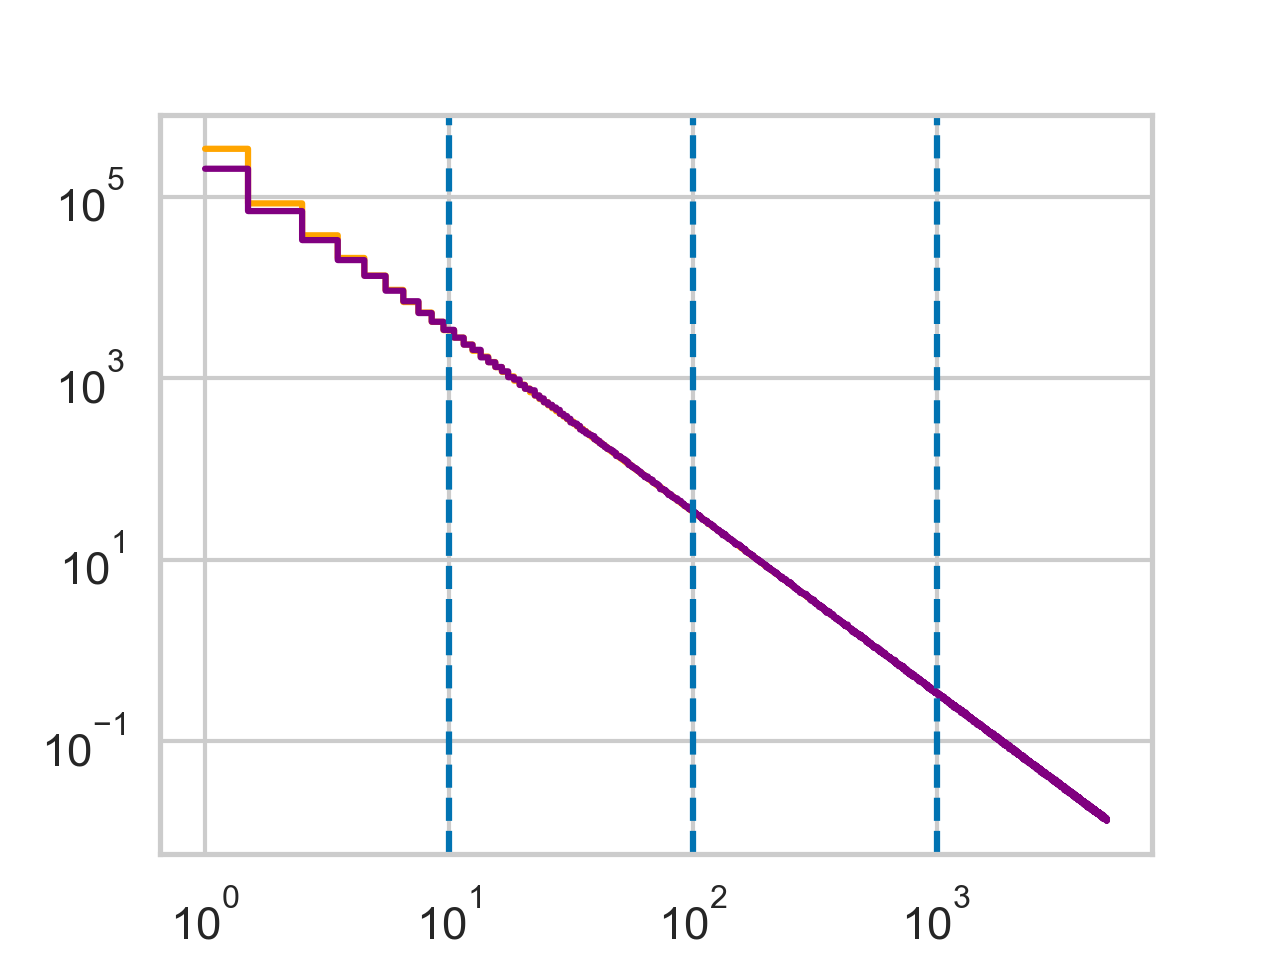

In [29]:
plt.figure()
#plt.loglog(avg_ps1.freq, avg_ps1.power, ds="steps-mid", color="black")
#plt.loglog(avg_ps1.freq, mps, ds="steps-mid", color="red")

plt.loglog(avg_ps_rn.freq, mps_rn, ds="steps-mid", color="orange")
plt.loglog(avg_ps_rn.freq, avg_ps_rn.power, ds="steps-mid", color="purple")

for idx in idx_all:
    plt.axvline(idx, ls="dashed")

## Generating Simulated Data

We're now ready to generate simulated data. We're going to simulate many periodograms and cospectra, but only store the information we need. 

**TODO**: Increase number of simulations after I'm finished writing everything down here.

In [40]:
# the number of simulations to run
nsim = 10000 


fourier1_all, fourier2_all, csd_all, csd_normed_all = [], [], [], []
fourier1_small, fourier2_small = [], []
fourier_squared_test, fourier_squared_test_lc1 = [], []
fdiff_all = []
lc1_counts_all, lc2_counts_all = [], []
lc1_all, lc2_all = [], []
ps1_all, ps2_all = [], []

for i in tqdm(range(nsim)):
    #print(i)
    lc = sim.simulate(plidx_true)
    
    try:
        counts1 = rng.poisson(lc.counts)
        counts2 = rng.poisson(lc.counts)
    except ValueError:
        continue
        
    lc1 = Lightcurve(lc.time, counts1, dt=dt, skip_checks=True)
    lc2 = Lightcurve(lc.time, counts2, dt=dt, skip_checks=True)
    
    lc1_counts_all.append(np.sum(lc1.counts))
    lc2_counts_all.append(np.sum(lc2.counts))
    
    #lc1_all.append(lc1.counts)
    #lc2_all.append(lc2.counts)
    
    fourier1 = scipy.fftpack.fft(lc1.counts)
    fourier2 = scipy.fftpack.fft(lc2.counts)

    freqs = scipy.fftpack.fftfreq(npoints, lc1.dt)

    fourier1 = fourier1[freqs>0]
    fourier2 = fourier2[freqs>0]

    freqs = freqs[freqs > 0]
    
    csd_real = fourier1.real * fourier2.real
    csd_imag = fourier1.imag * fourier2.imag

    csd = csd_real + csd_imag
    
    mean_nphot = np.sqrt(np.sum(lc1.counts)*np.sum(lc2.counts))

    ps1 = Powerspectrum(lc1, norm="leahy")
    ps2 = Powerspectrum(lc2, norm="leahy")
    
    f1 = fourier1[idx_all]
    f2 = fourier2[idx_all]

    # compute squared amplitudes
    fsq = f1.real * f2.real
    fsq_lc1 = f1.conj() * f1
    
    # Fourier amplitude differences
    fdiff = f1.real - f2.real
    
    fdiff_all.append(fdiff)
    
    fourier1_small.append(f1)
    fourier2_small.append(f2)
    
    fourier1_all.append(fourier1)
    fourier2_all.append(fourier2)

    fourier_squared_test.append(fsq)
    fourier_squared_test_lc1.append(fsq_lc1)
    
    csd_all.append(csd[idx_all])
    csd_normed_all.append(2.*csd[idx_all]/mean_nphot)


100%|██████████| 10000/10000 [01:48<00:00, 91.91it/s]


In [41]:
lc1_counts_all = np.array(lc1_counts_all)
lc2_counts_all = np.array(lc2_counts_all)

fourier1_small = np.array(fourier1_small)
fourier2_small = np.array(fourier2_small)

fourier1_all = np.array(fourier1_all)
fourier2_all = np.array(fourier2_all)

fdiff_all = np.array(fdiff_all)
fourier_squared_test = np.array(fourier_squared_test)
fourier_squared_test_lc1 = np.array(fourier_squared_test_lc1)

csd_all = np.array(csd_all)
csd_normed_all = np.array(csd_normed_all)

In [42]:
cov_all = []
for i in range(1500):
    cov_all.append(np.cov(fourier1_all[:,i].real, fourier2_all[:,i].real))

cov_all = np.array(cov_all)

In [43]:
cov_all[0]

array([[5.06681119e+11, 5.06678537e+11],
       [5.06678537e+11, 5.06686040e+11]])

In [44]:
cov_all_flat = cov_all.reshape((1500, 4))

In [45]:
corr_coeff_real, corr_coeff_imag = [], []
for i in range(1500):
    corr_coeff_real.append(np.corrcoef(fourier1_all[:,i].real, fourier2_all[:,i].real)[0,1])
    corr_coeff_imag.append(np.corrcoef(fourier1_all[:,i].imag, fourier2_all[:,i].imag)[0,1])


Great. Let's save some of those numbers:

In [46]:
np.savetxt(datadir + "lc_counts_all.dat", 
           np.array([lc1_counts_all, lc2_counts_all]).T)

#np.savetxt(datadir + "fourier_all.dat", 
#           np.hstack([fourier1_all, fourier2_all, fdiff_all]))

np.savetxt(datadir + "fourier_small.dat", 
           np.hstack([fourier1_small, fourier2_small, fdiff_all]))


np.savetxt(datadir + "fsquared_all.dat", 
           np.hstack([fourier_squared_test, fourier_squared_test_lc1]))

np.savetxt(datadir + "csd_all.dat", np.hstack([csd_all, csd_normed_all]))

np.savetxt(datadir + "cov_all.dat", cov_all_flat)

np.savetxt(datadir + "corrcoeff.dat", np.array([avg_ps_rn.freq[:1500], corr_coeff_real, corr_coeff_imag]))

In [47]:
ps1_all = np.array(ps1_all)
ps2_all = np.array(ps2_all)

fourier1_all = np.array(fourier1_all)
fourier2_all = np.array(fourier2_all)

csd_all = np.array(csd_all)
csd_normed_all = np.array(csd_normed_all)

lc1_all = np.array(lc1_all)
lc2_all = np.array(lc2_all)



In [48]:
np.savetxt("ps1_all_test.dat", ps1_all)

## Distributions of Fourier Amplitudes